# Emotional impact of slurs, pejorative and obscene words on Vent

After building the robust Vent dataset with \~10M comments on 88 categories, we want to study the approaches of other related work. Obscene words are often filtered out or not present in emotion data sets because of their origin, but they constitute an integral part of emotional language. In this notebook, we look at the proportion of obscene words per category.

In [7]:
import pandas as pd
import requests

GOOGLE_BAD_WORDS = 'https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/badwordslist/badwords.txt'
GOOGLE_PROFANITY_WORDS = 'https://raw.githubusercontent.com/RobertJGabriel/Google-profanity-words/master/list.txt'
BAD_WORDS = set(requests.get(GOOGLE_BAD_WORDS).text.splitlines())
PROFANITY_WORDS = set(requests.get(GOOGLE_PROFANITY_WORDS).text.splitlines())

TOTAL_BAD_WORD_SET = BAD_WORDS | PROFANITY_WORDS
len(TOTAL_BAD_WORD_SET)

763

In [10]:
vent = pd.read_parquet('../preprocessed/vent-robust.parquet')

In [12]:
vent['obscene_words'] = [[bad_word for bad_word in TOTAL_BAD_WORD_SET if bad_word in text] for text in vent.text]

In [14]:
vent['num_obscene'] = [len(bad_words) for bad_words in vent.obscene_words]

In [15]:
vent['has_obscene'] = vent['num_obscene'] > 0

In [52]:
emotion_obscene_df = vent.groupby(['emotions_label', 'emotion_categories_label', 'has_obscene']).size().reset_index()
emotion_obscene_df.columns = ['emotions_label', 'emotion_categories_label', 'has_obscene', 'num_instances']

In [53]:
emo_df = pd.read_csv('../data/emotions_clean.csv')
cat_df = pd.read_csv('../data/emotion_categories_clean.csv')

emo_indices = {i: str(n) for i, n in enumerate(emo_df.name.sort_values().tolist())}
cat_indices = {i: str(n) for i, n in enumerate(cat_df.name.sort_values().tolist())}


emotion_obscene_df['emotion'] = [emo_indices[emo] for emo in emotion_obscene_df.emotions_label.tolist()]
emotion_obscene_df['category'] = [cat_indices[cat] for cat in emotion_obscene_df.emotion_categories_label.tolist()]

In [61]:
# Compute emotion and category obscenity levels
emotion_freqs = emotion_obscene_df.groupby(['emotion', 'category']).num_instances.sum().reset_index()
emotion_freqs.columns = ['emotion', 'category', 'total_instances']

emotion_obscene = emotion_obscene_df.merge(emotion_freqs, on=['emotion', 'category'], how='inner')
emotion_obscene['obscene_pct'] = emotion_obscene.num_instances / emotion_obscene.total_instances
emotion_obscene = emotion_obscene[emotion_obscene.has_obscene][['emotion', 'obscene_pct']]

category_totals = emotion_obscene_df.groupby(['category', 'has_obscene']).num_instances.sum().reset_index()
category_totals.columns = ['category', 'has_obscene', 'obscene_totals']

category_freqs = emotion_obscene_df.groupby(['category']).num_instances.sum().reset_index()
category_freqs.columns = ['category', 'total_category_instances']

category_full = category_totals.merge(category_freqs, on='category', how='inner')
category_full['cat_obscene_pct'] = category_full.obscene_totals / category_full.total_category_instances

category_obscene = category_full[category_full.has_obscene][['category', 'cat_obscene_pct']]

In [148]:
full_df = emotion_obscene_df.groupby(['emotion', 'category']).num_instances.sum().reset_index()
full_df.columns = ['emotion', 'category', 'num_instances']

with_emo = full_df.merge(emotion_obscene, on='emotion', how='inner')
with_cat = with_emo.merge(category_obscene, on='category', how='inner')

with_cat.sort_values('cat_obscene_pct')

,emotion,category,num_instances,obscene_pct,cat_obscene_pct
87,Thankful,Positivity,61306,0.136381,0.137878
85,Safe,Positivity,33816,0.151378,0.137878
84,Optimistic,Positivity,57325,0.117174,0.137878
83,Motivated,Positivity,39121,0.130186,0.137878
82,Hyped,Positivity,103273,0.135486,0.137878
...,...,...,...,...,...
54,Furious,Anger,48592,0.404429,0.324827
55,Irritated,Anger,108982,0.335202,0.324827
56,Jealous,Anger,22317,0.191155,0.324827
48,Angry,Anger,63286,0.371283,0.324827


In [101]:
with_cat.obscene_pct.max()

0.40442871254527496

In [104]:
with_cat[with_cat.emotion == 'Inspired']

,emotion,category,num_instances,obscene_pct,cat_obscene_pct
14,Inspired,Creativity,53161,0.131036,0.159196


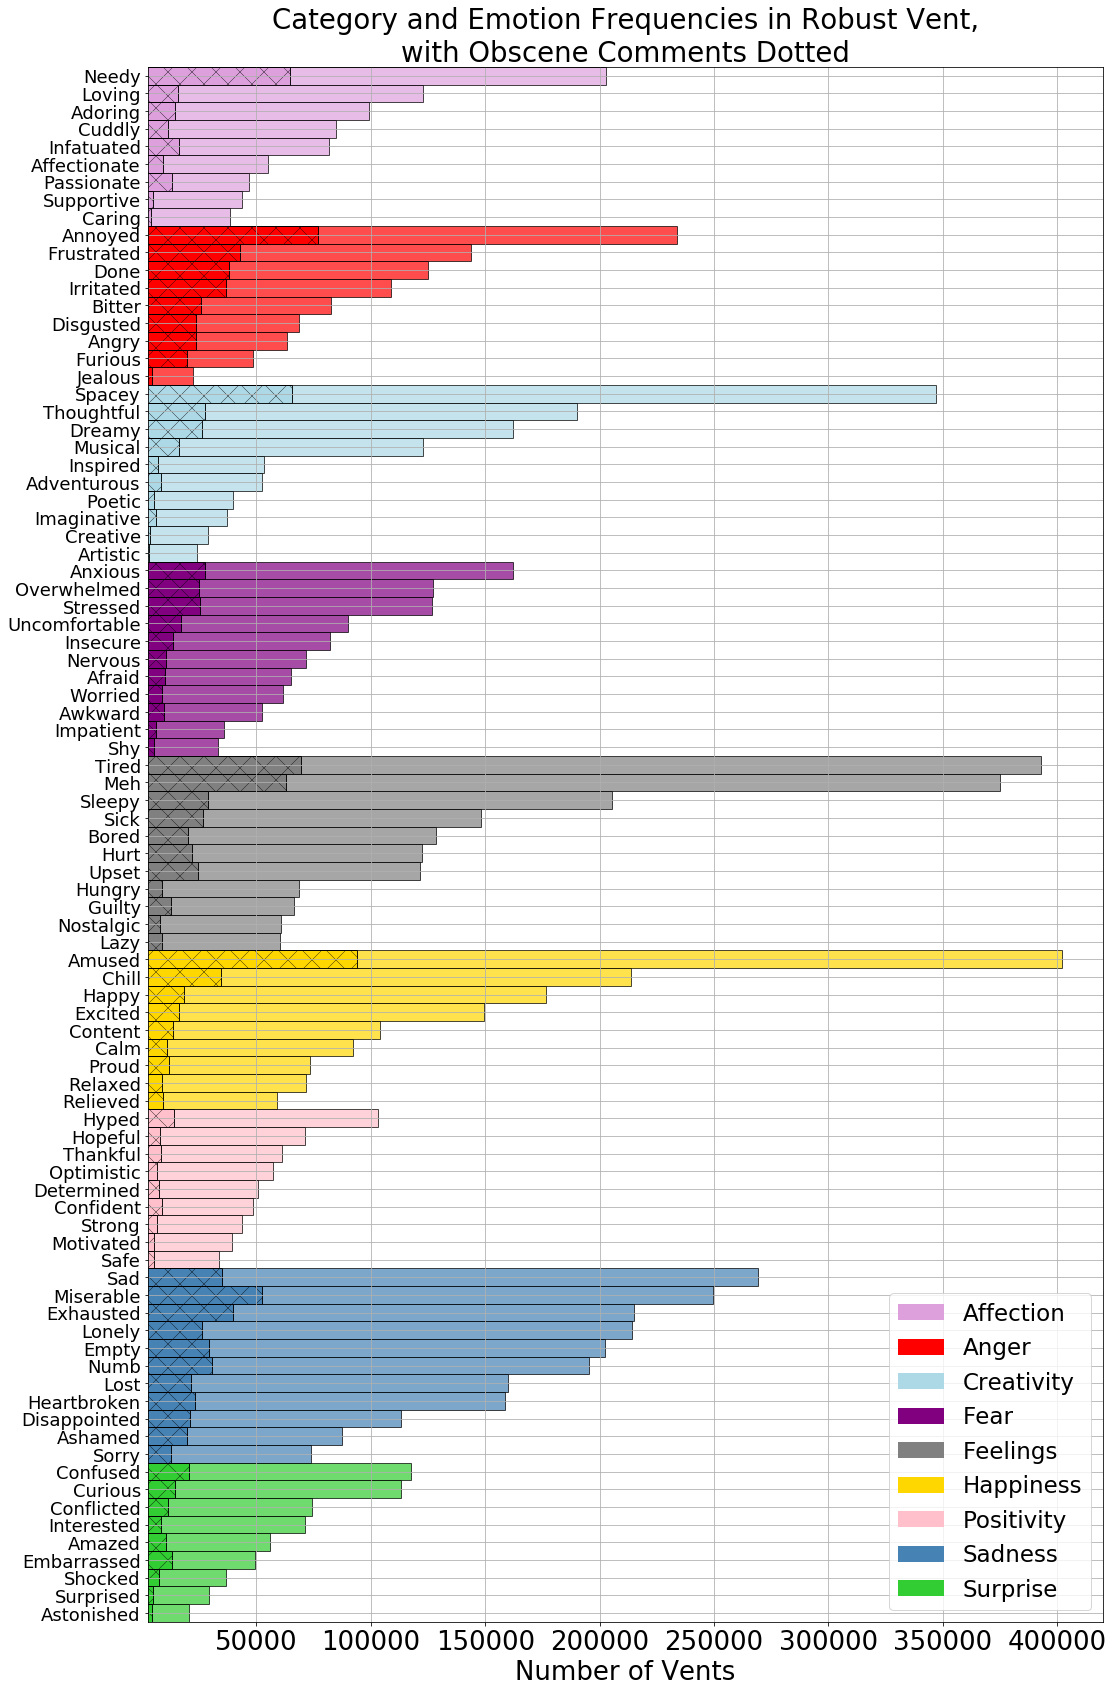

In [155]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

by_count = with_cat.sort_values(['category', 'num_instances'], ascending=[False, True])

num_emos = len(full_df.emotion.unique())

# Prepare the data
y_pos = np.arange(0.5, num_emos, 1.0) 
categories = by_count.category.tolist()
category_set = sorted(set(categories))
num_cats = len(category_set)
color_list = ['plum', 'red', 'lightblue', 'purple', 'grey', 'gold', 'pink', 'steelblue', 'limegreen']
color_map = {cat: col for cat, col in zip(category_set, color_list)}
colors = [color_map[cat] for cat in categories]
plt.rcParams.update({'hatch.color': 'black', 'hatch.linewidth': 0.367155323})

# Set the environment
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(16, 24))
#plt.xscale('log')
#plt.xlim(2.5e3, 1e6)
plt.xlim(2.5e3, 4.2e5)
plt.ylim(0, num_emos)
plt.yticks(y_pos, by_count.emotion.tolist())

# Plot each line with hatches
for category in category_set:
    y, c, obs, cat, col, hat = zip(*[t for t in zip(y_pos, by_count.num_instances.tolist(), by_count.obscene_pct.tolist(), categories, colors, hatches) if t[3] == category])
    col = col[0]
    hat = hat[0]
    obs = np.asarray(obs)
    plt.barh(y, c * obs, label=cat, color=col, left=0, hatch='x', height=1, edgecolor='k')
    plt.barh(y, c * (1 - obs), label=cat, color=col, left=c * obs, height=1, edgecolor='k', alpha=0.7)

matplotlib.rcParams.update({'font.size': 23})
plt.xlabel('Number of Vents', fontsize=26)
plt.xticks(fontsize=26)
plt.title('Category and Emotion Frequencies in Robust Vent,\nwith Obscene Comments Dotted')
plt.legend(handles=[mpatches.Patch(facecolor=color_map[cat], label=cat) for cat in category_set]) #  hatch=hatch_map[cat]
plt.grid()
plt.tight_layout()
plt.savefig('../output/RobustVentEmotionAndCategoryFrequenciesWithBadwords.pdf')

In [147]:
len(vent)

9745787